# Popularity Analysis

In [1]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import math
pd.set_option('display.max_columns', 500)

## Preprocessing and feature extraction
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

## Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor

## Model selection and fine tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

from statsmodels.formula.api import ols

In [ ]:
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
# import json
# import pandas as pd
# from spotipy.oauth2 import SpotifyClientCredentials
# credentials = json.load(open('../authorization.json'))
# client_id = credentials['client_id']
# client_secret = credentials['client_secret']
# client_credentials_manager = SpotifyClientCredentials(client_id=client_id,client_secret=client_secret)
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout = 5)

# Import data

## Audio features

In [2]:
%%bigquery audio_feature
SELECT * FROM snappy-boulder-378707.AudioFeatures.AudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
audio_feature.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature'],
      dtype='object')

In [17]:
audio_feature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.000,0.000289,0,-26.453,1,0.0000,0.9240,0.959000,0.1110,0.0000,0.000,66tcVcibuPYWs182LeINwu,189600,0
1,0.125,0.126000,0,-16.168,1,0.0364,0.1700,0.836000,0.1070,0.0303,162.399,1QVTJS7UUFWryqJ459TeL2,120000,3
2,0.125,0.031700,0,-23.849,1,0.0397,0.9560,0.819000,0.1250,0.0398,82.889,63LuatqjEm6RW3i469H4W0,846253,4
3,0.125,0.073400,0,-21.889,0,0.0351,0.5530,0.875000,0.1760,0.0347,96.982,7BmRd83zm8CHffrAPe2ZR7,710000,4
4,0.125,0.009780,0,-36.518,1,0.0412,0.9360,0.812000,0.1140,0.0380,72.172,3fwtXQDY5TliCI1CiAqs8U,178983,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74851,0.756,0.913000,11,-3.486,0,0.0523,0.2340,0.000000,0.0431,0.8690,110.955,7g9UMHzfI9w8StnZLVh8jV,196253,4
74852,0.881,0.696000,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.7810,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4
74853,0.881,0.361000,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.7990,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4
74854,0.881,0.441000,11,-6.278,0,0.0646,0.4800,0.000009,0.1190,0.8040,138.014,5wfllwdjglyQislkskYLBv,221240,4


## Tracks info

In [3]:
%%bigquery track_info
SELECT * FROM snappy-boulder-378707.TrackClearInfo.TrackClearInfo
WHERE popularity <> 0 and available_markets <> 0

Query is running:   0%|          |

Downloading:   0%|          |

In [23]:
track_info.head()

,id,name,album_id,artist_id,popularity,explicit,available_markets,extract_date
0,01SJW4s3EoRKN3A9mEPM8p,"Two Pieces for 2 pianos, Op. 58: I. Russian Ro...",4F63ZJbW8taPie57Yva3yk,1Ut6lBfgWMEoQZcHw0N6Ca;24kGrCKxX5OW1eq0mNk15V;...,1,0,1,2023-03-24
1,0prvB1hCLNQ2noJHkk7eKk,Adore,0hMWa3WyMRE1kYS9W4B7x6,5mqguTgtaoCMNMZD6txCh6,2,0,1,2023-03-24
2,3f5wbUEe7fR9eUq8Iift2L,Paper Throne,0hMWa3WyMRE1kYS9W4B7x6,5mqguTgtaoCMNMZD6txCh6,2,0,1,2023-03-24
3,6PPI2uXo2PpaoSf0EAu0rP,The Fiddle And The Drum,7k4QpUXGhOvp9U1bHy0OCH,1y2rqr1xpuz2ia93MQ9eEC,2,0,1,2023-03-24
4,7kOkTwCTBX53CRCKn4cbay,Quintessence,0ipDkptOYYaaB2MHXy5VWe,4ze7HHThfzYo15SuunBKhd,2,0,1,2023-03-24


## Album info

In [4]:
%%bigquery release_date
SELECT id,release_date FROM snappy-boulder-378707.TrackClearInfo.AlbumInfo

Query is running:   0%|          |

Downloading:   0%|          |

In [46]:
release_date

,id,release_date
0,6qo8bLXjZSYwCU5I6PaN4b,1970-01-01
1,73QdC5qhvKIf8NmoL6Foqt,2005-09-30
2,6O8BafrfHOLH6V2v3dsPV2,2016-04-05
3,4HsmQL9oNk7RPiD3sohwgk,2017-08-30
4,4ODaVW6oS0jRXMZKEkuJon,2017-08-30
...,...,...
74916,2fMGewLRioOoYUCgZocVHS,2008-01-01
74917,6ScYJCZCqiclKWdERP8stI,2021-01-16
74918,6ScYJCZCqiclKWdERP8stI,2021-01-16
74919,0RsNQJd8Em0kBK5BDTdAkb,2020-08-31


## Artist_info

In [192]:
%%bigquery artist_info
SELECT distinct track_id,avg(followers) as followers,avg(popularity) as popularity FROM snappy-boulder-378707.TrackClearInfo.ArtistInfo
GROUP BY track_id

Query is running:   0%|          |

Downloading:   0%|          |

In [193]:
artist_info

,track_id,followers,popularity
0,4n4ZVRf5L2AWU63RWt6bvt,2985.0,0.0
1,6fuTdkCGJ7hsFsOEmks2YJ,1222.5,3.0
2,2THox1skKzbJSSXZx7vYa0,5.0,0.0
3,7rKGvXnpU864MlZBrqM8P2,57.0,4.0
4,71foFS0nD6tAZC9BdsVc9G,84.0,0.0
...,...,...,...
13996,0TlLq3lA83rQOYtrqBqSct,73394437.0,98.0
13997,4frLb7nWtsz2ymBE6k2GRP,61258181.0,99.0
13998,3DrjZArsPsoqbLzUZZV1Id,70297154.0,100.0
13999,5xTtaWoae3wi06K5WfVUUH,70297154.0,100.0


## Merge data

In [194]:
df = pd.merge(audio_feature, track_info, on="id", how="inner")
del df['extract_date']

In [195]:
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,album_id,artist_id,popularity,explicit,available_markets
0,0.619,0.437,4,-7.623,0,0.0244,0.4490,0.001840,0.2920,0.536,90.972,4XhdM1Ku9JM4abVuRWAsgk,195164,4,Dum Dum,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,59,0,183
1,0.613,0.443,4,-7.502,0,0.0247,0.3490,0.000000,0.2370,0.604,91.044,6McBFhOohQvx0zWkoISnap,195164,4,Dum Dum - English Version,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,57,0,183
2,0.674,0.742,0,-6.374,1,0.0384,0.0117,0.000003,0.2810,0.604,135.007,32IMgcVhysYW12NRvMLp8c,186000,4,Want It All (feat. Evalyn),22MkBC5l2Zi9atm66fE0Jq,24V5UY0nChKpnb1TBPJhCw;68WwJXWrpo1yVOOIZjLSeT,30,0,182
3,0.602,0.493,5,-5.695,1,0.0443,0.8250,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181
4,0.602,0.493,5,-5.695,1,0.0443,0.8250,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,63,0,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74586,0.756,0.913,11,-3.486,0,0.0523,0.2340,0.000000,0.0431,0.869,110.955,7g9UMHzfI9w8StnZLVh8jV,196253,4,DOTCH,7GecM6HV4Q6EV95PTin5AK,4muJrGMndyYWqZtfk8OWy4,3,0,184
74587,0.881,0.696,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.781,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4,Morado,7ynTaSXD9esXkgY0GG8UFd,1vyhD5VmyZ7KMfW5gqLgo5,63,0,184
74588,0.881,0.361,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.799,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4,Check the Rhime,1p12OAWwudgMqfMzjMvl2a,09hVIj6vWgoCDtT03h8ZCa,64,0,184
74589,0.881,0.441,11,-6.278,0,0.0646,0.4800,0.000009,0.1190,0.804,138.014,5wfllwdjglyQislkskYLBv,221240,4,Day 'N' Nite (nightmare),2S8AWAM0nxyFy66YnUfIs3,0fA0VVWsXO9YnASrzqfmYu,70,0,3


In [198]:
df = pd.merge(release_date, df, left_on="id", right_on="album_id",how="inner")
df

,id_x,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_y,duration_ms,time_signature,name,album_id,artist_id,popularity,explicit,available_markets
0,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181
1,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,63,0,181
2,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181
3,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,63,0,181
4,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177533,6ScYJCZCqiclKWdERP8stI,2021-01-16,0.2700,0.1490,10,-21.207,1,0.0458,0.994,0.922,0.1080,0.5050,179.153,72YOzYeqT7Y7sK9O2esWbk,225467,1,"Horn Concerto No. 4 in E Flat, K.495: III. Ron...",6ScYJCZCqiclKWdERP8stI,4NJhFmfw43RLBLjQvxDuRS;2DO4p3CPDnInsJfg0jFfaF;...,43,0,184
177534,6ScYJCZCqiclKWdERP8stI,2021-01-16,0.1250,0.0205,10,-24.870,1,0.0440,0.993,0.888,0.1110,0.0930,84.244,00vOdEvR4Tc70EkWherEny,282493,4,"Horn Concerto No. 4 in E-Flat Major, K. 495: I...",6ScYJCZCqiclKWdERP8stI,4NJhFmfw43RLBLjQvxDuRS;08C4m48uN8PsFIPgTS1KqK;...,36,0,184
177535,6ScYJCZCqiclKWdERP8stI,2021-01-16,0.2700,0.1490,10,-21.207,1,0.0458,0.994,0.922,0.1080,0.5050,179.153,72YOzYeqT7Y7sK9O2esWbk,225467,1,"Horn Concerto No. 4 in E Flat, K.495: III. Ron...",6ScYJCZCqiclKWdERP8stI,4NJhFmfw43RLBLjQvxDuRS;2DO4p3CPDnInsJfg0jFfaF;...,43,0,184
177536,0RsNQJd8Em0kBK5BDTdAkb,2020-08-31,0.0769,0.0846,2,-25.997,1,0.0450,0.922,0.929,0.1130,0.0586,176.329,0DqFXzLtKkj9JO421NJpl1,363253,4,"Suite No. 3 in D Major, BWV 1068: II. Air",0RsNQJd8Em0kBK5BDTdAkb,5aIqB5nVVvmFsvSdExz408;29BEmD7wvKp6F5GTCcejY3;...,64,0,95


In [202]:
df = pd.merge(df,artist_info, left_on="id_y", right_on="track_id",how="inner")
df

,id_x,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_y,duration_ms,time_signature,name,album_id,artist_id,popularity_x,explicit,available_markets,track_id,followers,popularity_y
0,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181,38tKvVe3iURKRFm5X50zLZ,1930984.0,82.0
1,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,63,0,181,38tKvVe3iURKRFm5X50zLZ,1930984.0,82.0
2,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181,38tKvVe3iURKRFm5X50zLZ,1930984.0,82.0
3,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,63,0,181,38tKvVe3iURKRFm5X50zLZ,1930984.0,82.0
4,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.6020,0.4930,5,-5.695,1,0.0443,0.825,0.000000,0.3640,0.2810,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181,38tKvVe3iURKRFm5X50zLZ,1930984.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39692,0oOnAxUrSLRJTNv8YZafUk,2020-09-26,0.2060,0.0201,4,-26.470,0,0.0574,0.683,0.060700,0.1080,0.1690,75.042,1bzZ07QjPJoXsjdinN8jfj,267613,4,"Concerto In D Major For 2 Violins, Strings & C...",0oOnAxUrSLRJTNv8YZafUk,2QOIawHpSlOwXDvSqQ9YJR;1Ru2MsKaiEbw3TPXeEelQq;...,31,0,95,1bzZ07QjPJoXsjdinN8jfj,439547.6,48.2
39693,0zwLgWWAnvNNULTLS5Wo9g,2021-01-19,0.5240,0.0577,10,-22.067,0,0.0519,0.922,0.000004,0.0985,0.3780,66.073,5uMP8DUgwlLc3GdqSZkXkV,252171,4,"Schweigt stille, plaudert nicht Cantata, BWV 2...",0zwLgWWAnvNNULTLS5Wo9g,5aIqB5nVVvmFsvSdExz408;7cIdAeGd445NFOMJ3fr64K;...,37,0,95,5uMP8DUgwlLc3GdqSZkXkV,797393.6,54.8
39694,2fMGewLRioOoYUCgZocVHS,2008-01-01,0.1930,0.2970,9,-16.337,1,0.0796,0.901,0.022900,0.4680,0.1070,78.036,4HYFxTh9Zebhe1HuJt8Yl5,306293,3,"La Bohème / Act 2: ""Quando m'en vo'"" (Musetta'...",2fMGewLRioOoYUCgZocVHS,0OzxPXyowUEQ532c9AmHUR;1XLi3usPxxOgkEAxivBKZ1;...,15,0,130,4HYFxTh9Zebhe1HuJt8Yl5,48127.7,36.9
39695,0RsNQJd8Em0kBK5BDTdAkb,2020-08-31,0.0769,0.0846,2,-25.997,1,0.0450,0.922,0.929000,0.1130,0.0586,176.329,0DqFXzLtKkj9JO421NJpl1,363253,4,"Suite No. 3 in D Major, BWV 1068: II. Air",0RsNQJd8Em0kBK5BDTdAkb,5aIqB5nVVvmFsvSdExz408;29BEmD7wvKp6F5GTCcejY3;...,64,0,95,0DqFXzLtKkj9JO421NJpl1,1066140.5,68.5


In [168]:
del df['id']
del df['album_id']

In [173]:
df.columns = ['id_album', 'release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'id_track', 'duration_ms', 'time_signature', 'name',
       'artist_id', 'popularity_track', 'explicit',
       'available_markets','followers', 'popularity_artist']

In [196]:
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,album_id,artist_id,popularity,explicit,available_markets
0,0.619,0.437,4,-7.623,0,0.0244,0.4490,0.001840,0.2920,0.536,90.972,4XhdM1Ku9JM4abVuRWAsgk,195164,4,Dum Dum,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,59,0,183
1,0.613,0.443,4,-7.502,0,0.0247,0.3490,0.000000,0.2370,0.604,91.044,6McBFhOohQvx0zWkoISnap,195164,4,Dum Dum - English Version,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,57,0,183
2,0.674,0.742,0,-6.374,1,0.0384,0.0117,0.000003,0.2810,0.604,135.007,32IMgcVhysYW12NRvMLp8c,186000,4,Want It All (feat. Evalyn),22MkBC5l2Zi9atm66fE0Jq,24V5UY0nChKpnb1TBPJhCw;68WwJXWrpo1yVOOIZjLSeT,30,0,182
3,0.602,0.493,5,-5.695,1,0.0443,0.8250,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181
4,0.602,0.493,5,-5.695,1,0.0443,0.8250,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,63,0,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74586,0.756,0.913,11,-3.486,0,0.0523,0.2340,0.000000,0.0431,0.869,110.955,7g9UMHzfI9w8StnZLVh8jV,196253,4,DOTCH,7GecM6HV4Q6EV95PTin5AK,4muJrGMndyYWqZtfk8OWy4,3,0,184
74587,0.881,0.696,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.781,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4,Morado,7ynTaSXD9esXkgY0GG8UFd,1vyhD5VmyZ7KMfW5gqLgo5,63,0,184
74588,0.881,0.361,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.799,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4,Check the Rhime,1p12OAWwudgMqfMzjMvl2a,09hVIj6vWgoCDtT03h8ZCa,64,0,184
74589,0.881,0.441,11,-6.278,0,0.0646,0.4800,0.000009,0.1190,0.804,138.014,5wfllwdjglyQislkskYLBv,221240,4,Day 'N' Nite (nightmare),2S8AWAM0nxyFy66YnUfIs3,0fA0VVWsXO9YnASrzqfmYu,70,0,3


# Data Transformation & Preprocessing

In [175]:
numeric_columns = ['danceability', 'energy', 'loudness', 
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 
       'popularity_track',  'available_markets','followers','popularity_artist']
catego_columns = ['mode','explicit','key', 'time_signature']

In [176]:
imputer_numeric = SimpleImputer(strategy='mean', missing_values=np.nan)
df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
df[catego_columns] = imputer_catego.fit_transform(df[catego_columns])

In [177]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_track,explicit,available_markets,followers,popularity_artist
count,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06,1.677090e+06
mean,5.578773e-01,6.559485e-01,5.278814e+00,-7.596586e+00,5.971558e-01,8.220457e-02,2.817034e-01,1.460912e-01,1.804638e-01,4.439653e-01,1.208739e+02,2.199872e+05,3.918897e+00,4.500548e+01,4.035919e-02,1.689560e+02,7.824048e+06,7.051980e+01
std,1.919645e-01,2.606636e-01,3.552314e+00,5.916781e+00,4.904701e-01,7.957770e-02,3.025976e-01,3.088578e-01,1.406147e-01,2.473842e-01,2.930859e+01,6.744825e+04,3.928125e-01,1.477336e+01,1.968003e-01,4.353982e+01,1.284133e+07,1.226836e+01
min,5.800000e-02,2.810000e-04,0.000000e+00,-4.377000e+01,0.000000e+00,2.210000e-02,1.110000e-06,0.000000e+00,7.240000e-03,0.000000e+00,3.239300e+01,1.594900e+04,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.410000e-01,4.850000e-01,2.000000e+00,-9.112000e+00,0.000000e+00,3.650000e-02,2.550000e-02,0.000000e+00,9.410000e-02,2.500000e-01,9.809300e+01,1.878000e+05,4.000000e+00,3.600000e+01,0.000000e+00,1.820000e+02,6.984050e+05,6.400000e+01
50%,5.880000e-01,7.290000e-01,5.000000e+00,-5.416000e+00,1.000000e+00,5.190000e-02,1.490000e-01,2.170000e-06,1.220000e-01,4.440000e-01,1.199890e+02,2.111430e+05,4.000000e+00,4.500000e+01,0.000000e+00,1.830000e+02,3.868252e+06,6.900000e+01
75%,7.060000e-01,8.670000e-01,8.000000e+00,-3.786000e+00,1.000000e+00,9.470000e-02,4.940000e-01,8.580000e-03,2.320000e-01,6.420000e-01,1.399610e+02,2.481600e+05,4.000000e+00,5.500000e+01,0.000000e+00,1.840000e+02,1.075920e+07,8.400000e+01
max,9.840000e-01,1.000000e+00,1.100000e+01,8.780000e-01,1.000000e+00,9.590000e-01,9.960000e-01,9.950000e-01,9.940000e-01,9.820000e-01,2.207770e+02,3.259708e+06,5.000000e+00,1.000000e+02,1.000000e+00,1.850000e+02,1.106634e+08,1.000000e+02


## EDA

### Distribution of variables

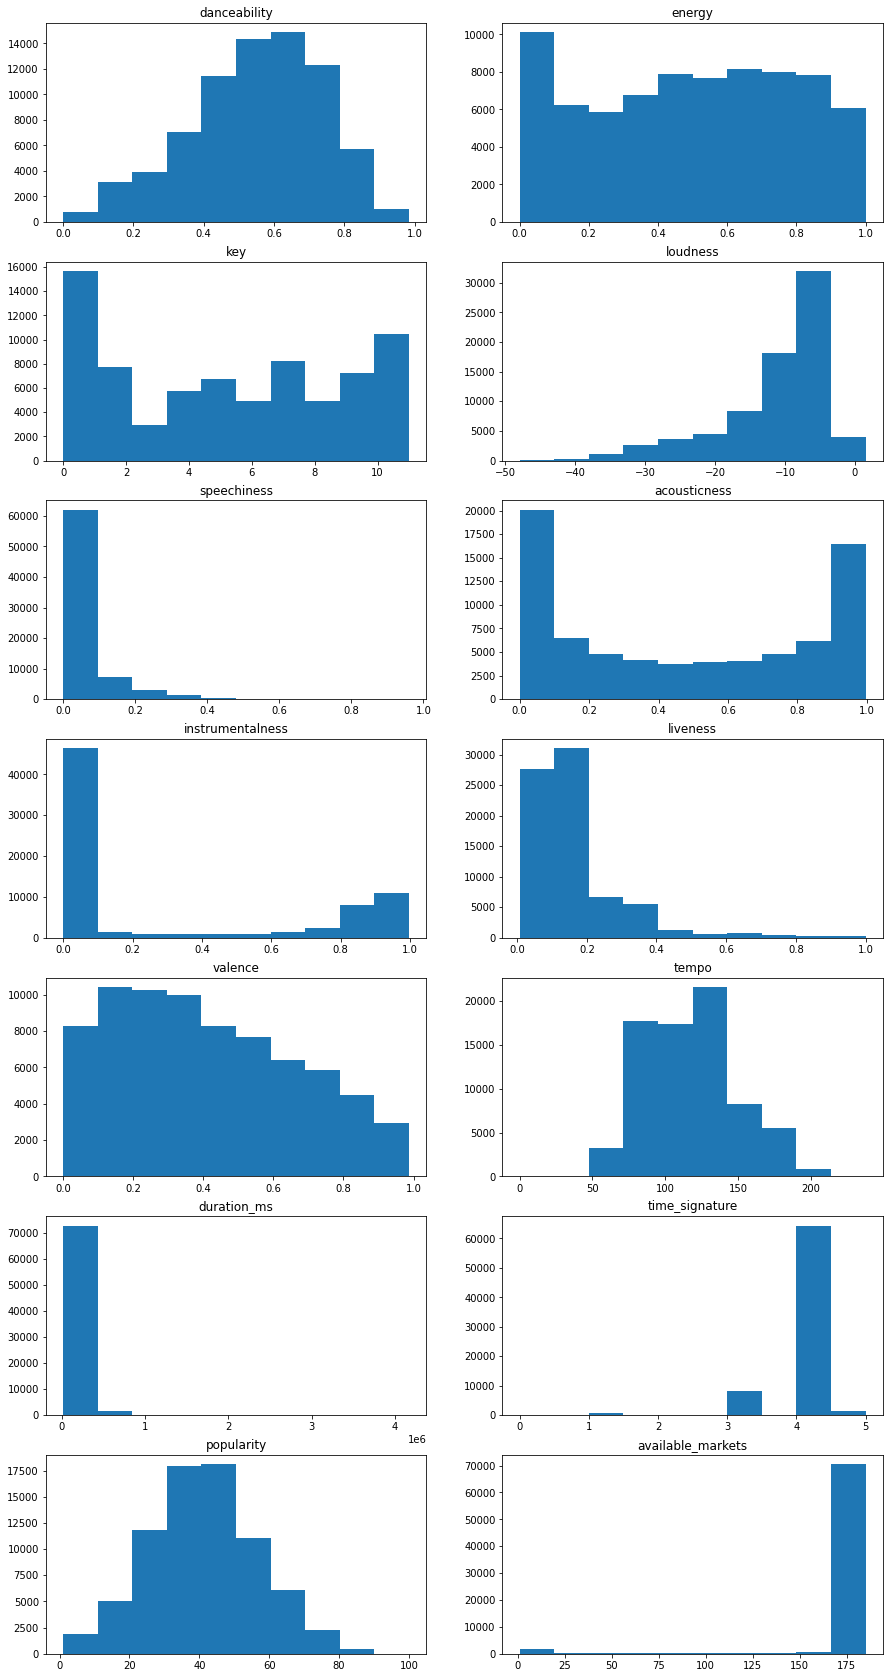

In [95]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2,figsize=(15,30))
ax1.hist(df[['danceability']])
ax2.hist(df[['energy']])
ax3.hist(df[['key']])
ax4.hist(df[['loudness']])
ax5.hist(df[['speechiness']])
ax6.hist(df[['acousticness']])
ax7.hist(df[['instrumentalness']])
ax8.hist(df[['liveness']])
ax9.hist(df[['valence']])
ax10.hist(df[['tempo']])
ax11.hist(df[['duration_ms']])
ax12.hist(df[['time_signature']])
ax13.hist(df[['popularity']])
ax14.hist(df[['available_markets']])

ax1.title.set_text('danceability')
ax2.title.set_text('energy')
ax3.title.set_text('key')
ax4.title.set_text('loudness')
ax5.title.set_text('speechiness')
ax6.title.set_text('acousticness')
ax7.title.set_text('instrumentalness')
ax8.title.set_text('liveness')
ax9.title.set_text('valence')
ax10.title.set_text('tempo')
ax11.title.set_text('duration_ms')
ax12.title.set_text('time_signature')
ax13.title.set_text('popularity')
ax14.title.set_text('available_markets')

Text(0, 0.5, 'frequency')

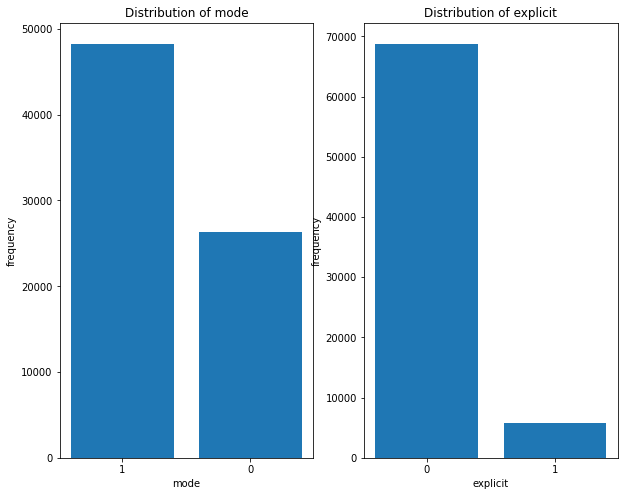

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ax[0].bar(    
    x=list(map(str,df[catego_columns[0]].value_counts().keys().tolist())),
    height=df[catego_columns[0]].value_counts().values
    )
ax[0].set_title("Distribution of mode")
ax[0].set_xlabel("mode")
ax[0].set_ylabel("frequency")
ax[1].bar(    
    x=list(map(str,df[catego_columns[1]].value_counts().keys().tolist())),
    height=df[catego_columns[1]].value_counts().values
    )
ax[1].set_title("Distribution of explicit")
ax[1].set_xlabel("explicit")
ax[1].set_ylabel("frequency")

Text(0.5, 1.0, 'Popularity Based on Time Signature')

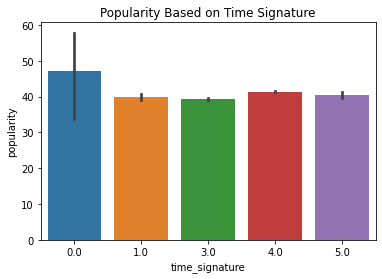

In [13]:
sns.barplot(x = 'time_signature', y = 'popularity', data = df)
plt.title('Popularity Based on Time Signature')

Text(0.5, 1.0, 'Popularity Based on Key')

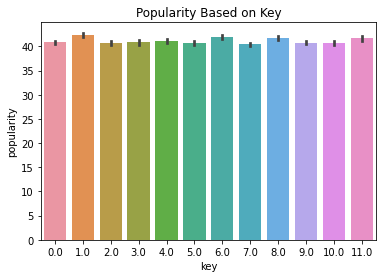

In [14]:
sns.barplot(x = 'key', y = 'popularity', data = df)
plt.title('Popularity Based on Key')

Text(0.5, 1.0, 'Popularity Based on Mode')

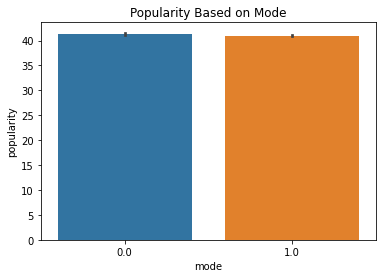

In [15]:
sns.barplot(x = 'mode', y = 'popularity', data = df)
plt.title('Popularity Based on Mode')

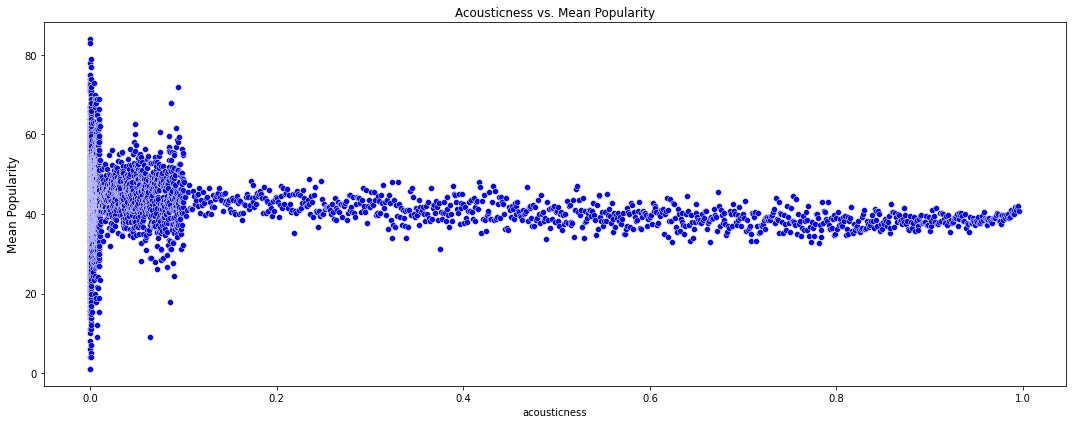

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('acousticness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['acousticness'], y=ax1_data['popularity'], color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

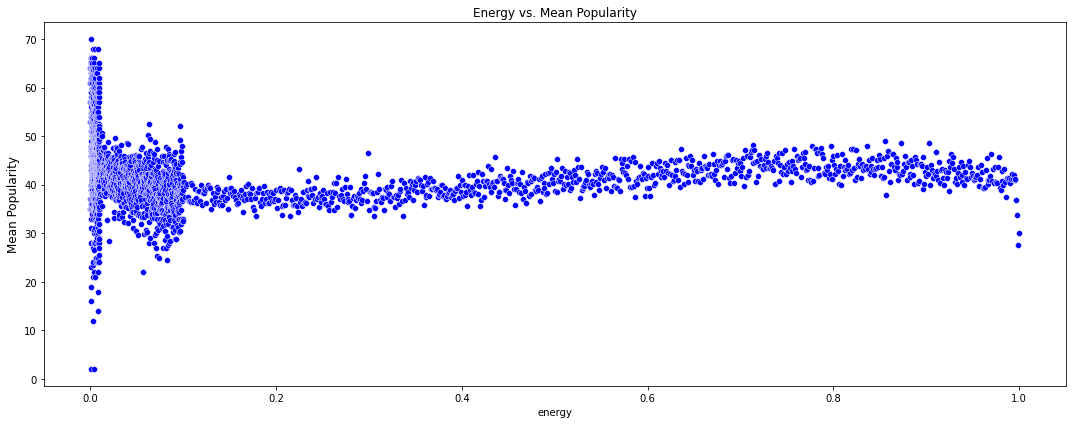

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('energy')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['energy'], y=ax1_data['popularity'], color='blue', ax=ax)
ax.set_title('Energy vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

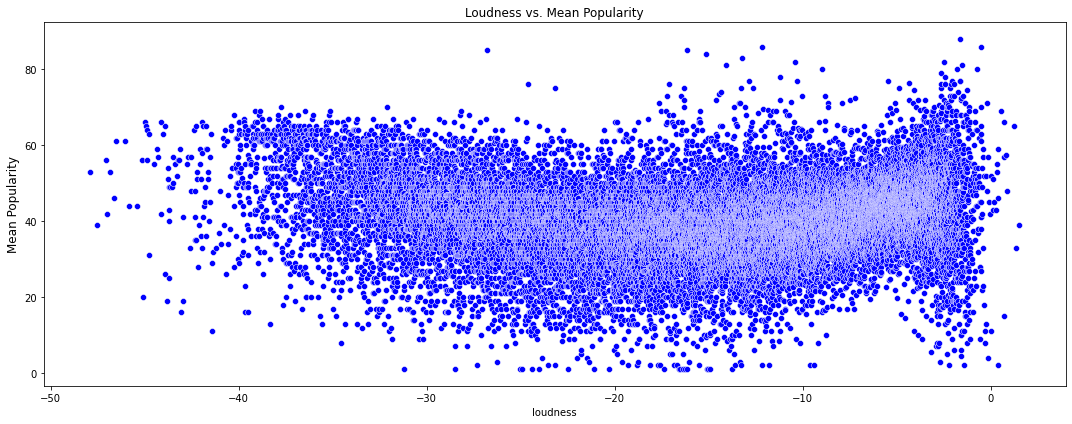

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('loudness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['loudness'], y=ax1_data['popularity'], color='blue', ax=ax)
ax.set_title('Loudness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

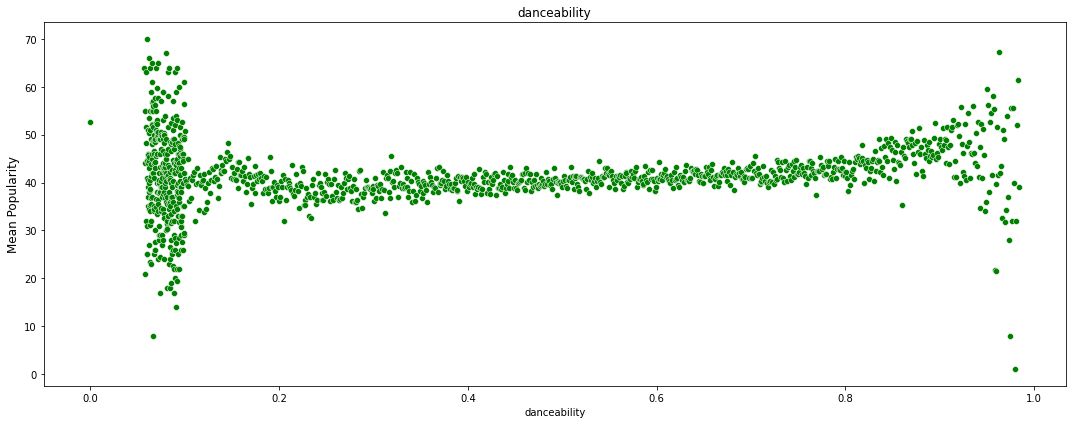

In [18]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='danceability', y='popularity', data=ax_data, color='green', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

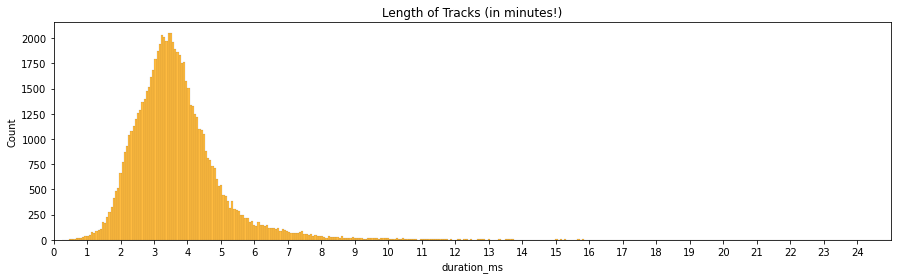

In [19]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.histplot(df['duration_ms']/60000, color='orange')
ax.set_title('Length of Tracks (in minutes!)')
ax.set_xticks(range(0,25,1))
ax.set_xlim(0,25)
plt.show()

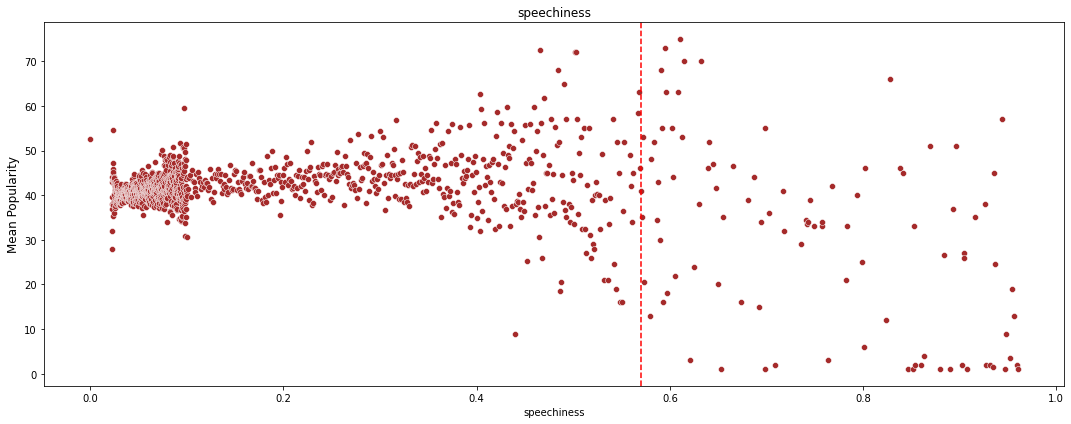

In [21]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('speechiness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='speechiness', y='popularity', data=ax_data, color='brown', ax=ax)
ax.axvline(x=0.57, ymin=0, ymax=1, color='red', linestyle='dashed')
ax.set_title('speechiness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

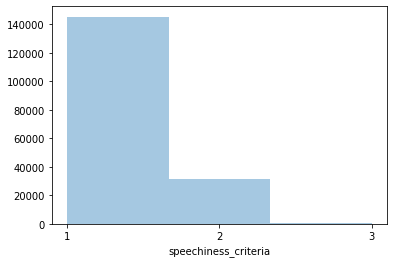

In [60]:
criteria= [df['speechiness'].between(0, 0.1),
           df['speechiness'].between(0.1000001, 0.850),
           df['speechiness'].between(0.8500001, 1)]
values = [1, 2, 3]
df['speechiness_criteria'] = np.select(criteria, values, 0)
fig, ax = plt.subplots()
sns.distplot(df['speechiness_criteria'],ax=ax, kde=False, bins=3 )
ax.set_xticks(range(1,4))
plt.show()

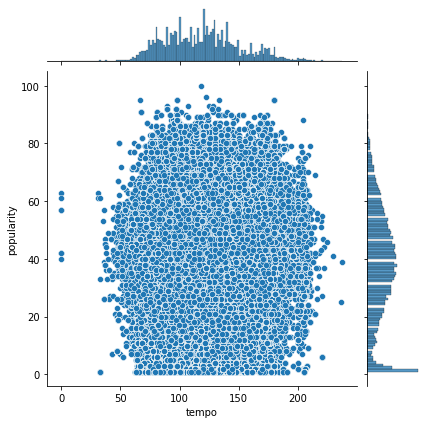

In [93]:
sns.jointplot(x='tempo', y='popularity', data=df)
plt.show()

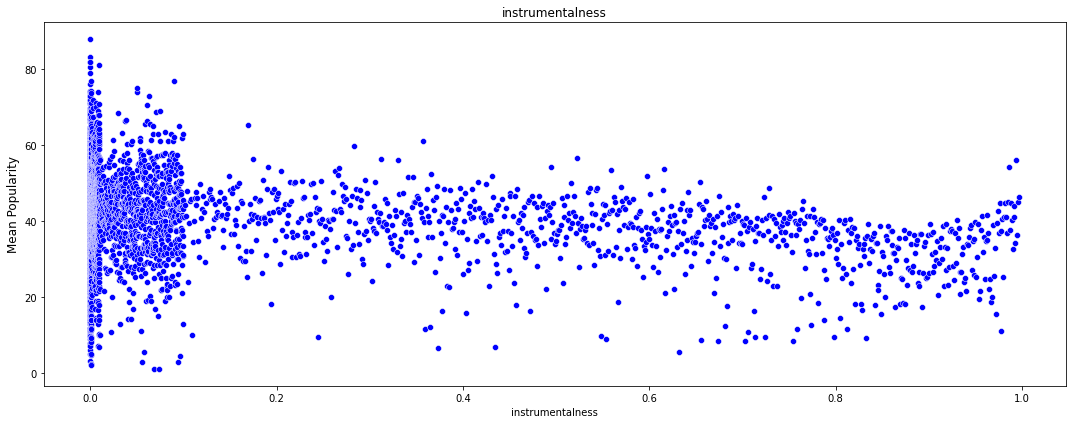

In [34]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='instrumentalness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

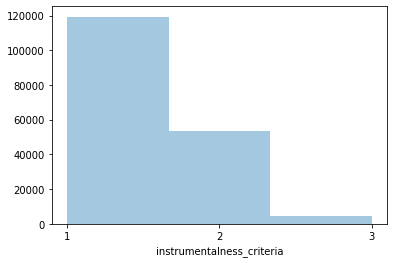

In [35]:
criteria= [df['instrumentalness'].between(0, 0.1),
           df['instrumentalness'].between(0.1000001, 0.95),
           df['instrumentalness'].between(0.950001, 1)]
values = [1, 2, 3]
df['instrumentalness_criteria'] = np.select(criteria, values, 0)
fig, ax = plt.subplots()
sns.distplot(df['instrumentalness_criteria'],ax=ax, kde=False, bins=3 )
ax.set_xticks(range(1,4))
plt.show()

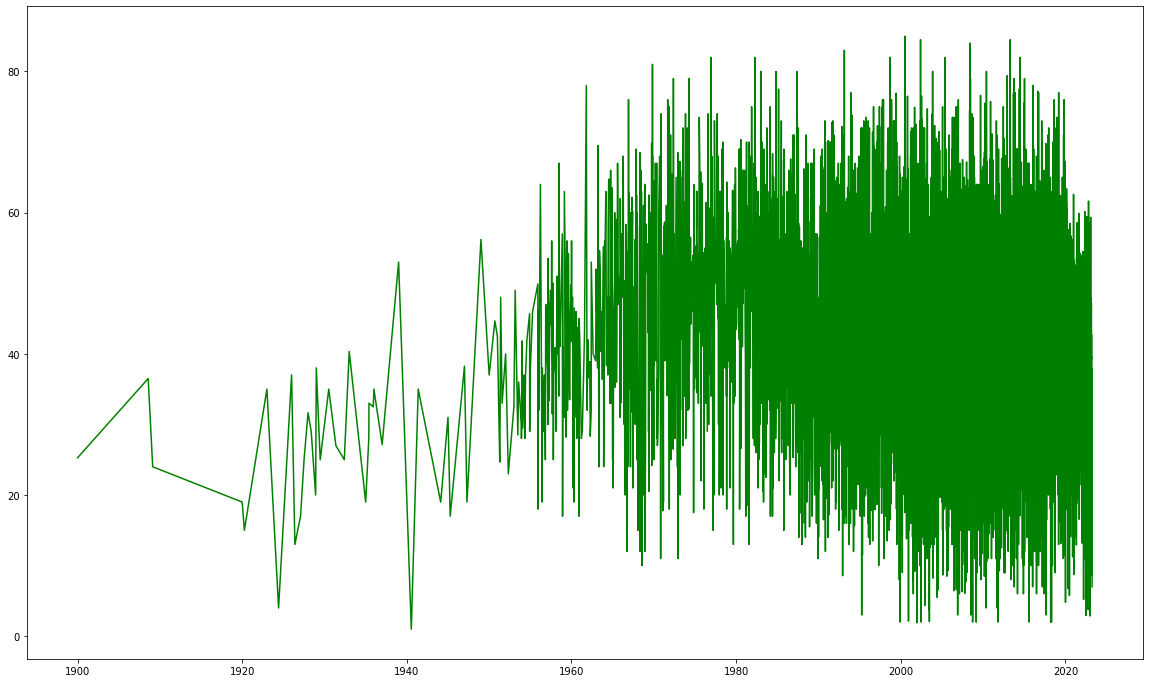

In [60]:
date_with_mean_pop = df.groupby('release_date')['popularity'].mean().to_frame().reset_index()
plt.figure(figsize=(20,12))
plt.plot_date(date_with_mean_pop[['release_date']],date_with_mean_pop[['popularity']], 'g')

## Correlation between features

<Axes: >

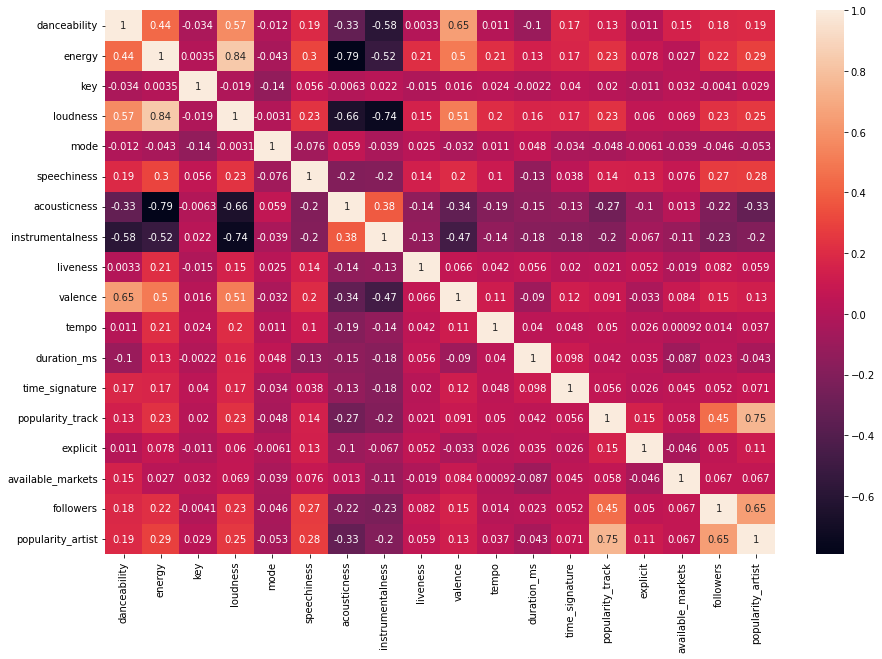

In [178]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

Observe that acousticness and energy have the highest correlation. In future steps, need to eliminate one of variable to compare results. Given how the two plots "Popularity vs. acousticness" and "Popularity vs. energy" look, we will keep energy and discard acousticness.

In [18]:
# df.drop(columns=['acousticness'], inplace=True)

# Model Buiding

In [107]:
# del df['instrumentalness_criteria']

In [ ]:
# df['mode'].corr(df['popularity'])

In [179]:
df

,id_album,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_track,duration_ms,time_signature,name,artist_id,popularity_track,explicit,available_markets,followers,popularity_artist
0,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.602,0.4930,5.0,-5.695,1.0,0.0443,0.825,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326.0,4.0,this is what losing someone feels like,164Uj4eKjl6zTBKfJLFKKK,69.0,0.0,181.0,1930984.0,82.0
1,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.602,0.4930,5.0,-5.695,1.0,0.0443,0.825,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326.0,4.0,this is what losing someone feels like,164Uj4eKjl6zTBKfJLFKKK,69.0,0.0,181.0,1930984.0,82.0
2,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.602,0.4930,5.0,-5.695,1.0,0.0443,0.825,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326.0,4.0,this is what losing someone feels like,164Uj4eKjl6zTBKfJLFKKK,69.0,0.0,181.0,1930984.0,82.0
3,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.602,0.4930,5.0,-5.695,1.0,0.0443,0.825,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326.0,4.0,this is what losing someone feels like,164Uj4eKjl6zTBKfJLFKKK,69.0,0.0,181.0,1930984.0,82.0
4,4fU1IAiidcbKjProAZuoLF,2023-03-17,0.602,0.4930,5.0,-5.695,1.0,0.0443,0.825,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326.0,4.0,this is what losing someone feels like,164Uj4eKjl6zTBKfJLFKKK,69.0,0.0,181.0,1930984.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677085,33Ow1zrnDZND0gJFibphEf,1999-10-04,0.540,0.3220,4.0,-10.635,0.0,0.0735,0.992,0.000041,0.0946,0.652,71.709,4hFZeihCVWuFsxMyal96k8,175640.0,4.0,Big Town Playboy,11TvYVOGy2ceBJiMRhlBx4,24.0,0.0,184.0,200.0,14.0
1677086,2KDC9MOVhSPFY3ANMB6aDw,1993-01-01,0.336,0.2490,5.0,-15.092,1.0,0.0391,0.922,0.000188,0.1090,0.400,119.690,1TmJIO8XZkItg9p1p9gFoZ,210333.0,3.0,Just One More Chance - 1931 Single Version,6ZjFtWeHP9XN7FeKSUe80S,28.0,0.0,168.0,445568.0,61.0
1677087,2KDC9MOVhSPFY3ANMB6aDw,1993-01-01,0.336,0.2490,5.0,-15.092,1.0,0.0391,0.922,0.000188,0.1090,0.400,119.690,1TmJIO8XZkItg9p1p9gFoZ,210333.0,3.0,Just One More Chance - 1931 Single Version,6ZjFtWeHP9XN7FeKSUe80S,28.0,0.0,168.0,445922.0,61.0
1677088,7MtvcTxFnvzzhkmRsPiHA2,2011-01-01,0.556,0.2120,7.0,-11.154,1.0,0.0917,0.859,0.000068,0.1200,0.628,179.835,3KYlO842OFhn0z2uEjICjh,148573.0,4.0,Sweet Sue (Just You),4RvXA7BDgqNgGDjsSSJnPc,21.0,0.0,184.0,24794.0,34.0


First, we need to split the data.

If we consider the usecase of Spotify, the company certainly wants to predict the popularity of future songs. Thus, we should split the dataset between songs issued before a certain year and songs issued after it.

We will make a train set of all the songs previous to 2022-04-06, a validation set composed of the songs issued between 2022-04-06 and 2022-12-22 to fine-tune and select our models (18% of the whole dataset), and a test set composed of the songs issued on and after 2022-12-22 (10% of the total dataset).

In [180]:
X = df.sort_values(by='release_date').drop(columns=['popularity_track','id_album','id_track','artist_id','name']).copy()
y = df.sort_values(by='release_date')['popularity_track'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [181]:
X_train.tail(5)

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
1006834,2021-09-15,0.706,0.893,9.0,-3.954,0.0,0.15,0.134,0.0,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0
1006833,2021-09-15,0.706,0.893,9.0,-3.954,0.0,0.15,0.134,0.0,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0
1006832,2021-09-15,0.706,0.893,9.0,-3.954,0.0,0.15,0.134,0.0,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0
1006831,2021-09-15,0.706,0.893,9.0,-3.954,0.0,0.15,0.134,0.0,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0
1006830,2021-09-15,0.706,0.893,9.0,-3.954,0.0,0.15,0.134,0.0,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0


In [182]:
X_val.tail(5)

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
1182635,2022-10-23,0.299,0.402,0.0,-12.706,1.0,0.0374,0.171,0.813,0.0696,0.0508,124.932,190689.0,3.0,0.0,183.0,563708.0,69.0
1182660,2022-10-23,0.203,0.110,0.0,-24.825,0.0,0.0375,0.601,0.923,0.1120,0.0357,104.190,151233.0,4.0,0.0,183.0,563708.0,69.0
1182659,2022-10-23,0.203,0.110,0.0,-24.825,0.0,0.0375,0.601,0.923,0.1120,0.0357,104.190,151233.0,4.0,0.0,183.0,563708.0,69.0
1182658,2022-10-23,0.203,0.110,0.0,-24.825,0.0,0.0375,0.601,0.923,0.1120,0.0357,104.190,151233.0,4.0,0.0,183.0,563708.0,69.0
1182657,2022-10-23,0.203,0.110,0.0,-24.825,0.0,0.0375,0.601,0.923,0.1120,0.0357,104.190,151233.0,4.0,0.0,183.0,563708.0,69.0


In [183]:
import datetime as dt
X_train['release_date']=X_train['release_date'].map(dt.datetime.toordinal)
X_val['release_date']=X_val['release_date'].map(dt.datetime.toordinal)
X_test['release_date']=X_test['release_date'].map(dt.datetime.toordinal)

In [184]:
X_train

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
1309833,693596,0.550,0.290,10.0,-14.191,0.0,0.028,0.881,0.000076,0.1630,0.427,91.583,191467.0,4.0,0.0,181.0,19366.0,40.0
1309361,693596,0.550,0.290,10.0,-14.191,0.0,0.028,0.881,0.000076,0.1630,0.427,91.583,191467.0,4.0,0.0,181.0,19366.0,40.0
1309360,693596,0.550,0.290,10.0,-14.191,0.0,0.028,0.881,0.000076,0.1630,0.427,91.583,191467.0,4.0,0.0,181.0,19366.0,40.0
1309359,693596,0.550,0.290,10.0,-14.191,0.0,0.028,0.881,0.000076,0.1630,0.427,91.583,191467.0,4.0,0.0,181.0,19366.0,40.0
1309358,693596,0.550,0.290,10.0,-14.191,0.0,0.028,0.881,0.000076,0.1630,0.427,91.583,191467.0,4.0,0.0,181.0,19366.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006834,738048,0.706,0.893,9.0,-3.954,0.0,0.150,0.134,0.000000,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0
1006833,738048,0.706,0.893,9.0,-3.954,0.0,0.150,0.134,0.000000,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0
1006832,738048,0.706,0.893,9.0,-3.954,0.0,0.150,0.134,0.000000,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0
1006831,738048,0.706,0.893,9.0,-3.954,0.0,0.150,0.134,0.000000,0.0629,0.545,119.998,227653.0,4.0,0.0,183.0,6537943.0,67.0


We will use the artists and the songs title later on, for now we drop the columns.

In [185]:
ct = ColumnTransformer([('minmax', MinMaxScaler(), ['release_date','loudness', 'tempo', 'duration_ms','available_markets','followers','popularity_artist']),
                        ('categorical', OneHotEncoder(), ['key','mode','time_signature','explicit']),
#                         ('drop_cols', 'drop', ['name'])
                       ],
                       remainder='passthrough')

ct.fit(X_train)

X_train_preprocessed = pd.DataFrame(ct.transform(X_train).tolist())
X_val_preprocessed = pd.DataFrame(ct.transform(X_val).tolist())
X_test_preprocessed = pd.DataFrame(ct.transform(X_test).tolist())

In [188]:
X_train_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.0,0.662493,0.289954,0.129744,0.978261,0.000175,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.550,0.290,0.028,2,0.000076,0.1630,0.427
1,0.0,0.662493,0.289954,0.129744,0.978261,0.000175,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.550,0.290,0.028,2,0.000076,0.1630,0.427
2,0.0,0.662493,0.289954,0.129744,0.978261,0.000175,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.550,0.290,0.028,2,0.000076,0.1630,0.427
3,0.0,0.662493,0.289954,0.129744,0.978261,0.000175,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.550,0.290,0.028,2,0.000076,0.1630,0.427
4,0.0,0.662493,0.289954,0.129744,0.978261,0.000175,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.550,0.290,0.028,2,0.000076,0.1630,0.427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207499,1.0,0.891776,0.447747,0.158865,0.989130,0.059080,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.706,0.893,0.150,2,0.000000,0.0629,0.545
1207500,1.0,0.891776,0.447747,0.158865,0.989130,0.059080,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.706,0.893,0.150,2,0.000000,0.0629,0.545
1207501,1.0,0.891776,0.447747,0.158865,0.989130,0.059080,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.706,0.893,0.150,2,0.000000,0.0629,0.545
1207502,1.0,0.891776,0.447747,0.158865,0.989130,0.059080,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.706,0.893,0.150,2,0.000000,0.0629,0.545


In [186]:
from sklearn.preprocessing import FunctionTransformer
def instrumentalness_criteria(X):
    X.iloc[:,30] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.iloc[:,30]))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)
instrumentalness_tranformer.transform(X_train_preprocessed)
instrumentalness_tranformer.transform(X_val_preprocessed)
instrumentalness_tranformer.transform(X_test_preprocessed)

In [131]:
from sklearn.preprocessing import FunctionTransformer
def speechiness_criteria(X):
    X.iloc[:,28] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.85 else 2)), X.iloc[:,28]))

speechiness_tranformer = FunctionTransformer(speechiness_criteria)
speechiness_tranformer.transform(X_train_preprocessed)
speechiness_tranformer.transform(X_val_preprocessed)
speechiness_tranformer.transform(X_test_preprocessed)

In [142]:
print(X_train_preprocessed.iloc[:,33].corr(y_train))

0.5897340321381986


In [135]:
for col in X_train_preprocessed.columns:
    print(X_train_preprocessed[col].corr(y_train))

-0.058161379525294606
0.09621956312235881
0.024356237914415373
-0.024765160325839697
-0.06890698595570297
-0.01612382499426041
0.03235289977265316
-0.010217368131483844
-0.004031002805060849
3.7329025894028933e-05
-0.01618170478935305
0.02347077332655779
-0.02745180528133929
0.027501290379404686
-0.0049425367460844485
-0.012197750132756775
0.01985920789346818
0.046126559535942066
-0.046126559535942066
0.0035627736848905392
-0.013272195040747453
-0.04905436415507952
0.05501483366761618
-0.01833382870868999
-0.22447715877748636
0.22447715877748636
0.05215291622218731
0.11747578834586898
0.06945448608394601
-0.16891267242505126
-0.12473622993957395
0.008605059997228375
0.058079083815730057


KeyboardInterrupt: 

In [139]:
class ArtistsTransformer():
#   """ This transformer recives a DF with a feature 'artists' of dtype object
#       and convert the feature to a float value as follows:
#       1. Replace the data with the artists mean popularity
#       2. Replace values where artists appear less than MinCnt with y.mean()
#       3. Replace values where artists appear more than MaxCnt with 0
      
#       PARAMETERS:
#       ----------
#       MinCnt (int): Minimal treshold of artisits apear in dataset, default = 3
#       MaxCnt (int): Maximal treshold of artisits apear in dataset, default = 600

#       RERTURN:
#       ----------
#       A DataFrame with converted artists str feature to ordinal floats
#   """

  def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
      self.MinCnt = MinCnt
      self.MaxCnt = MaxCnt
      self.artists_df = None
  
  def fit (self, X, y):
      self.artists_df =  y.groupby(X.iloc[:,33]).agg(['mean', 'count'])
      self.artists_df.loc['unknown'] = [y.mean(), 1]
      self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
      self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
      return self

  def transform(self, X, y=None):
      X.iloc[:,33] = np.where(X.iloc[:,33].isin(self.artists_df.index), X.iloc[:,33], 'unknown')
      X.iloc[:,33] = X.iloc[:,33].map(self.artists_df['mean'])
      return X

In [140]:
# Apply AritistsTransformer on train and test seperatly
artists_transformer = ArtistsTransformer(MinCnt=2)
X_train_preprocessed = artists_transformer.fit(X_train_preprocessed, y_train).transform(X_train_preprocessed, y_train)
X_test = artists_transformer.transform(X_val_preprocessed, y_val)

In [48]:
# X_train_preprocessed.columns = ['release_date','loudness', 'tempo', 'duration_ms','available_markets','key_01',
#                                'key_02', 'key_03', 'key_04', 'key_05', 'key_06', 'key_07', 'key_08', 'key_09',
#                                'key_10','key_11','key_12','mode_01','mode_02','time_signature_01','time_signature_02',
#                                 'time_signature_03','time_signature_04','time_signature_05',
#                                 'explicit_01','explicit_02','danceability', 'energy', 'speechiness',  
#                                 'instrumentalness', 'liveness','valence']
# X_val_preprocessed.columns = ['release_date','loudness', 'tempo', 'duration_ms','available_markets','key_01',
#                                'key_02', 'key_03', 'key_04', 'key_05', 'key_06', 'key_07', 'key_08', 'key_09',
#                                'key_10','key_11','key_12','mode_01','mode_02','time_signature_01','time_signature_02',
#                                 'time_signature_03','time_signature_04','time_signature_05',
#                                 'explicit_01','explicit_02','danceability', 'energy', 'speechiness',  
#                                 'instrumentalness', 'liveness','valence']
# X_test_preprocessed.columns = ['release_date','loudness', 'tempo', 'duration_ms','available_markets','key_01',
#                                'key_02', 'key_03', 'key_04', 'key_05', 'key_06', 'key_07', 'key_08', 'key_09',
#                                'key_10','key_11','key_12','mode_01','mode_02','time_signature_01','time_signature_02',
#                                 'time_signature_03','time_signature_04','time_signature_05',
#                                 'explicit_01','explicit_02','danceability', 'energy', 'speechiness',  
#                                 'instrumentalness', 'liveness','valence']
# X_train_preprocessed

In [133]:
y_train = y_train / 100
y_val = y_val / 100
y_test = y_test/100
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [113]:
# verifictaion
nl = '\n'
print(f'X_train_preprocessed shape is: {X_train_preprocessed.shape} {nl}y_train shape is: {y_train.shape} {nl}X_val_preprocessed shape is: {X_val_preprocessed.shape} {nl}y_val shape is: {y_val.shape} {nl}X_test_preprocessed shape is: {X_test_preprocessed.shape} {nl}y_test shape is: {y_test.shape}')

X_train_preprocessed shape is: (127827, 32) 
y_train shape is: (127827,) 
X_val_preprocessed shape is: (31957, 32) 
y_val shape is: (31957,) 
X_test_preprocessed shape is: (17754, 32) 
y_test shape is: (17754,)


### Linear Regression (selected features only (corr > 0.2))

In [141]:
X_train_preprocessed.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.0,0.743677,0.446547,0.040663,0.978261,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.635,0.315,1,0.861,1,0.133,0.846,0.209783,1,1
1,0.0,0.733702,0.617622,0.036285,0.978261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.570,0.324,1,0.941,1,0.190,0.882,0.209783,1,1
2,0.0,0.682125,0.416025,0.041546,0.978261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.550,0.290,1,0.881,1,0.163,0.427,0.209783,1,1


In [19]:
X_train_preprocessed.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
count,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000,127827.000000
mean,0.906960,0.778551,0.541081,0.051608,0.945171,0.121852,0.089652,0.108733,0.034828,0.078661,0.091679,0.065706,0.110446,0.062545,0.097515,0.064337,0.074045,0.344802,0.655198,0.000063,0.008433,0.094565,0.883538,0.013401,0.936547,0.063453,0.554878,0.558287,0.071888,0.403980,0.179700,0.173960,0.444966
std,0.118197,0.136774,0.135509,0.021654,0.191234,0.327116,0.285684,0.311305,0.183346,0.269210,0.288573,0.247768,0.313446,0.242145,0.296658,0.245353,0.261846,0.475306,0.475306,0.007911,0.091445,0.292615,0.320779,0.114985,0.243777,0.243777,0.180375,0.278890,0.073354,0.355346,0.335115,0.139215,0.253177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000281,0.000000,0.000000,0.000000,0.007240,0.000000
25%,0.867003,0.734997,0.436801,0.041061,0.989130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.437000,0.344000,0.034400,0.054600,0.000000,0.095700,0.232000
50%,0.955727,0.821739,0.540338,0.048837,0.994565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.571000,0.594000,0.044200,0.311000,0.000028,0.118000,0.422000
75%,0.988064,0.870483,0.626639,0.058457,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.691000,0.799000,0.072700,0.753000,0.084100,0.205000,0.649000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.983000,1.000000,0.959000,0.996000,0.997000,1.000000,0.987000


In [151]:
from sklearn.metrics import mean_squared_error as mse
LR = LinearRegression()
cols = [col for col in X_train_preprocessed.columns if abs(X_train_preprocessed[col].corr(y_train))>0.1]

# Fit the model and
LR.fit(X_train_preprocessed.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train_preprocessed.drop(columns=cols)).clip(0, 1)

# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.5f}")

# #Predicting with the model
# y_test_pred = LR.predict(X_test.drop(columns=cols)).clip(0, 1)

# # RMSE Test
# LR_rmse = np.sqrt(mse(y_test, y_test_pred))
# print(f"RMSE Test = {LR_rmse:.5f}")

RMSE Train = 0.17366


In [152]:
cols

[24, 25, 27, 29, 30, 33]

In [153]:
#Predicting with the model
y_val_pred = LR.predict(X_val_preprocessed.drop(columns=cols)).clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_val, y_val_pred))
print(f"RMSE Val = {LR_rmse:.5f}")

RMSE Val = 0.20600


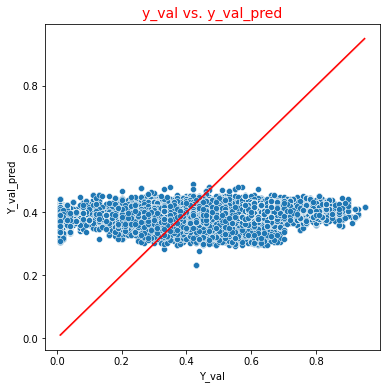

In [154]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_val, y=y_val_pred)
sns.lineplot(x=y_val, y=y_val, color='red', ax=ax)
ax.set_xlabel('Y_val')
ax.set_ylabel('Y_val_pred')
ax.set_title('y_val vs. y_val_pred', fontsize=14, color='red')
plt.show()

### Linear Regression (all features)

In [147]:
LR = LinearRegression()

# Fit the model and
LR.fit(X_train_preprocessed, y_train)

# Train Predicting with the model
y_train_pred2 = LR.predict(X_train_preprocessed).clip(0, 1)

# RMSE Train
LR_rmse2 = np.sqrt(mse(y_train, y_train_pred2))
print(f"RMSE Train = {LR_rmse2:.6f}")

RMSE Train = 0.137758


In [148]:
#Predicting with the model
y_val_pred = LR.predict(X_val_preprocessed).clip(0, 1)

# RMSE Test
LR_rmse2 = np.sqrt(mse(y_val, y_val_pred))
print(f"RMSE Test = {LR_rmse2:.6f}")

RMSE Test = 0.201406


In [30]:
# from IPython.display import display, Math

# def get_printable_equt(df, inter, coef):
#   equtation = '$y = ' + f'{inter:.2f} '
  
#   for i, co in enumerate(coef):
#     if i == len(coef) - 1:
#         equtation = equtation + f'+ {co:.2f} {(df.columns)[i]}$'
#     else:
#         equtation = equtation + f'+ {co:.2f} {(df.columns)[i]}'

#   return display(Math(equtation))

# get_printable_equt(X_train_preprocessed, LR.intercept_, LR.coef_)

<IPython.core.display.Math object>

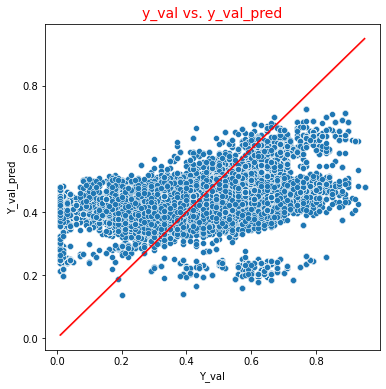

In [149]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_val, y=y_val_pred)
sns.lineplot(x=y_val, y=y_val, color='red', ax=ax)
ax.set_xlabel('Y_val')
ax.set_ylabel('Y_val_pred')
ax.set_title('y_val vs. y_val_pred', fontsize=14, color='red')
plt.show()

In [150]:
import statsmodels.api as sm
model = sm.OLS(list(y_train), X_train_preprocessed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     2530.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:47:12   Log-Likelihood:                 72006.
No. Observations:              127827   AIC:                        -1.439e+05
Df Residuals:                  127794   BIC:                        -1.436e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0239      0.004      6.705      0.000       0.017       0.031
1             -0.0388      0.006     -6.420      0.000      -0.051      -0.027
2             -0.0179      0.003     -6.014      0.000      -0.024      -0.012
3             -0.4315      0.019    -23.119      0.000      -0.468      -0.395
4              0.0084      0.002      4.123      0.000       0.004       0.012
5              0.0153      0.001     11.555      0.000       0.013       0.018
6              0.0307      0.001     20.946      0.000       0.028       0.034
7              0.0186      0.001     13.629      0.000       0.016       0.021
8              0.0259      0.002     12.361      0.000       0.022       0.030
9              0.0153      0.002     10.030      0.000       0.012       0.018
10             0.0194      0.001     13.409      0.000       0.017       0.022
11             0.0276      0.002     16.973      0.000       0.024       0.031
12             0.0122      0.001      8.893      0.000       0.009       0.015
13             0.0290      0.002     17.420      0.000       0.026       0.032
14             0.0159      0.001     11.268      0.000       0.013       0.019
15             0.0104      0.002      6.346      0.000       0.007       0.014
16             0.0163      0.002     10.337      0.000       0.013       0.019
17             0.1240      0.005     27.043      0.000       0.115       0.133
18             0.1125      0.005     24.604      0.000       0.104       0.121
19             0.1350      0.041      3.329      0.001       0.056       0.214
20             0.0251      0.009      2.791      0.005       0.007       0.043
21             0.0277      0.008      3.290      0.001       0.011       0.044
22             0.0268      0.008      3.202      0.001       0.010       0.043
23             0.0219      0.009      2.494      0.013       0.005       0.039
24             0.1010      0.005     22.227      0.000       0.092       0.110
25             0.1354      0.005     28.610      0.000       0.126       0.145
26            -0.0104      0.003     -3.411      0.001      -0.016      -0.004
27             0.0178      0.003      5.138      0.000       0.011       0.025
28             0.0530      0.009      5.609      0.000       0.034       0.071
29            -0.0518      0.002    -26.568      0.000      -0.056      -0.048
30            -0.0296      0.001    -27.924      0.000      -0.032      -0.028
31            -0.0338      0.003    -11.789      0.000      -0.039      -0.028
32             0.0068      0.002      3.129      0.002       0.003       0.011
33             0.5651      0.002    250.149      0.000       0.561       0.570
34            -0.0366      0.022     -1.629      0.103      -0.081       0.007
35             0.0010      0.024      0.039      0.969      -0.047       0.049
==

<Axes: ylabel='popularity'>

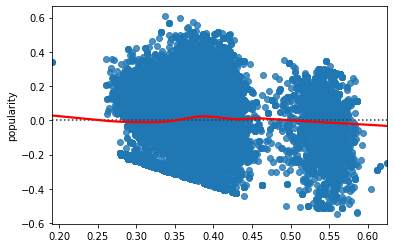

In [33]:
from statistics import mean 
resid = y_val - y_val_pred
sns.residplot(y =resid, x=y_val_pred, lowess=True,line_kws=dict(color="r"))

## Multilinear regression

In [106]:
lin_reg = LinearRegression()
reg = lin_reg.fit(X_train_preprocessed, y_train)
y_pred = lin_reg.predict(X_val_preprocessed).astype(float)
y_val = y_val.astype(float)
mean_squared_error(y_val, y_pred, squared=False)

19.03508593079868

In [120]:
from sklearn.metrics import r2_score
r2_score(y_val, y_val_pred)

0.02050374669395827

In [108]:
reg.score(X_train_preprocessed, y_train)

0.08360660198012593

In [10]:
# indep_features = ['danceability', 'energy', 'key', 'loudness', 'C(mode)',
#        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
#        'valence', 'tempo', 'duration_ms', 'time_signature',
#         'C(explicit)', 'available_markets']

In [11]:
# linear = ols(formula='popularity ~ ' + ' + '.join(indep_features), data=df).fit()
# linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     376.9
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:07:12   Log-Likelihood:            -3.0876e+05
No. Observations:               74584   AIC:                         6.176e+05
Df Residuals:                   74568   BIC:                         6.177e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             44.7327      0.830     53.906      0.000      43.106      46.359
C(mode)[T.1.0]        -0.0836      0.119     -0.702      0.483      -0.317       0.150
C(explicit)[T.1.0]    10.3501      0.226     45.741      0.000       9.907      10.794
danceability           1.7627      0.417      4.224      0.000       0.945       2.581
energy                 3.6348      0.479      7.588      0.000       2.696       4.574
key                   -0.0279      0.016     -1.754      0.079      -0.059       0.003
loudness              -0.3819      0.016    -24.267      0.000      -0.413      -0.351
speechiness           -8.2065      0.814    -10.080      0.000      -9.802      -6.611
acousticness          -4.7782      0.279    -17.152      0.000      -5.324      -4.232
instrumentalness      -4.9721      0.193    -25.784      0.000      -5.350      -4.594
liveness              -5.4406      0.444    -12.252      0.000      -6.311      -4.570
valence                0.4686      0.298      1.574      0.116      -0.115       1.052
tempo                 -0.0061      0.002     -3.222      0.001      -0.010      -0.002
duration_ms        -1.694e-05   6.21e-07    -27.271      0.000   -1.82e-05   -1.57e-05
time_signature         0.2126      0.125      1.699      0.089      -0.033       0.458
available_markets     -0.0147      0.002     -8.119      0.000      -0.018      -0.011
==============================================================================
Omnibus:                       38.285   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.897
Skew:                          -0.048   Prob(JB):                     5.90e-09
Kurtosis:                       2.947   Cond. No.                     3.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'residuals')

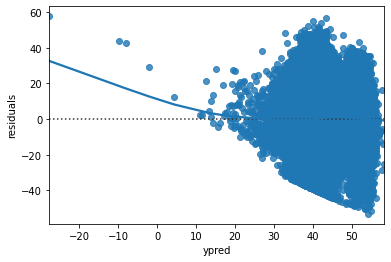

In [12]:
# sns.residplot(x=linear.fittedvalues, y=linear.resid, lowess=True)
# plt.xlabel('ypred')
# plt.ylabel('residuals')

In [116]:
# Lasso
lasso=Lasso()

lasso_fit = lasso.fit(X_train_preprocessed,y_train)

y_pred = lasso.predict(X_val_preprocessed)

mean_squared_error(y_val, y_pred, squared=False)

0.21204505566576215

In [117]:
lasso_fit.score(X_train_preprocessed,y_train)

0.0

In [114]:
# XGBoost regressor
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=20, learning_rate=0.01)

xgb_fit = xgb_regressor.fit(X_train_preprocessed, y_train)

y_pred = xgb_regressor.predict(X_val_preprocessed)

mean_squared_error(y_val, y_pred, squared=False)

23.47763184498725

In [118]:
# K-Nearest-Neighbors (KNN) regressor
neigh = KNeighborsRegressor(n_neighbors=7)

neigh_fit = neigh.fit(X_train_preprocessed, y_train)

y_pred=neigh.predict(X_val_preprocessed)

mean_squared_error(y_val, y_pred, squared=False)

0.217206927571345

In [121]:
r2_score(y_val, y_pred)

-0.08900335146980698

## Log regression

In [125]:
logr = ols(formula='np.log(popularity) ~ ' + ' + '.join(indep_features), data=df).fit()
logr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(popularity)   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     172.6
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:00:14   Log-Likelihood:            -1.3063e+05
No. Observations:              113457   AIC:                         2.613e+05
Df Residuals:                  113439   BIC:                         2.615e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.5416      0.146     24.273      0.000       3.256       3.828
C(mode)[T.1]            0.0130      0.016      0.823      0.410      -0.018       0.044
C(mode)[T.<NA>]        -0.4400      0.013    -32.749      0.000      -0.466      -0.414
C(explicit)[T.1]       -0.0270      0.005     -5.805      0.000      -0.036      -0.018
C(explicit)[T.<NA>]    -0.2159      0.016    -13.439      0.000      -0.247      -0.184
danceability            0.0586      0.063      0.937      0.349      -0.064       0.181
energy                 -0.3180      0.075     -4.227      0.000      -0.465      -0.171
key                     0.0007      0.002      0.308      0.758      -0.004       0.005
loudness                0.0206      0.004      4.728      0.000       0.012       0.029
speechiness            -0.0857      0.076     -1.122      0.262      -0.235       0.064
acousticness            0.0037      0.037      0.100      0.920      -0.069       0.077
instrumentalness       -0.0680      0.082     -0.830      0.407      -0.228       0.093
liveness                0.0216      0.052      0.412      0.680      -0.081       0.124
valence                 0.0418      0.040      1.053      0.293      -0.036       0.120
tempo                   0.0001      0.000      0.447      0.655      -0.000       0.001
duration_ms          1.621e-07      1e-07      1.620      0.105    -3.4e-08    3.58e-07
time_signature          0.0397      0.029      1.370      0.171      -0.017       0.097
available_markets       0.0013   5.46e-05     23.356      0.000       0.001       0.001
==============================================================================
Omnibus:                    38104.899   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124415.618
Skew:                          -1.731   Prob(JB):                         0.00
Kurtosis:                       6.786   Cond. No.                     1.49e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'residuals')

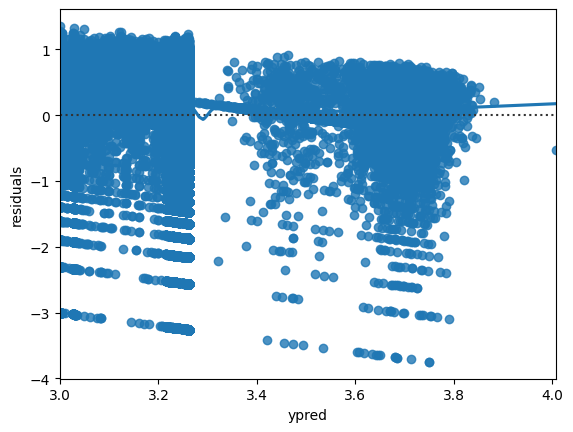

In [126]:
sns.residplot(x=logr.fittedvalues, y=logr.resid, lowess=True)
plt.xlabel('ypred')
plt.ylabel('residuals')

## Polynomial

In [134]:
indep_features = ['danceability', 'energy', 'key', 'loudness','mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature','explicit',
         'available_markets']

In [122]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
p2X_train = poly.fit_transform(X_train_preprocessed)

In [123]:
import statsmodels.api as sm
model = sm.OLS(y_train, p2X_train).fit()

In [124]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     58.56
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:36:26   Log-Likelihood:                 51422.
No. Observations:              127827   AIC:                        -1.020e+05
Df Residuals:                  127426   BIC:                        -9.813e+04
Df Model:                         400                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.029      0.667      0.505      -0.037       0.075
x1            -0.5295      0.033    -15.985      0.000      -0.594      -0.465
x2             0.4714      0.051      9.220      0.000       0.371       0.572
x3            -0.0993      0.033     -2.976      0.003      -0.165      -0.034
x4            -0.5515      0.144     -3.835      0.000      -0.833      -0.270
x5             0.2435      0.019     13.013      0.000       0.207       0.280
x6             0.0237      0.009      2.602      0.009       0.006       0.041
x7            -0.0143      0.009     -1.680      0.093      -0.031       0.002
x8             0.0056      0.008      0.739      0.460      -0.009       0.020
x9             0.0088      0.012      0.766      0.444      -0.014       0.032
x10            0.0468      0.009      5.491      0.000       0.030       0.064
x11            0.0140      0.008      1.842      0.066      -0.001       0.029
x12            0.0094      0.009      1.044      0.297      -0.008       0.027
x13           -0.0127      0.007     -1.848      0.065      -0.026       0.001
x14           -0.0333      0.012     -2.781      0.005      -0.057      -0.010
x15            0.0129      0.010      1.273      0.203      -0.007       0.033
x16           -0.0379      0.009     -4.166      0.000      -0.056      -0.020
x17           -0.0039      0.009     -0.430      0.667      -0.022       0.014
x18            0.0040      0.015      0.267      0.789      -0.025       0.033
x19            0.0151      0.015      1.018      0.309      -0.014       0.044
x20            0.0248      0.012      2.002      0.045       0.001       0.049
x21           -0.0208      0.019     -1.103      0.270      -0.058       0.016
x22           -0.0081      0.011     -0.715      0.475      -0.030       0.014
x23            0.0054      0.010      0.518      0.605      -0.015       0.026
x24            0.0178      0.019      0.964      0.335      -0.018       0.054
x25           -0.0191      0.015     -1.254      0.210      -0.049       0.011
x26            0.0382      0.019      2.016      0.044       0.001       0.075
x27           -0.1589      0.028     -5.696      0.000      -0.214      -0.104
x28           -0.0182      0.029     -0.629      0.529      -0.075       0.038
x29            0.1248      0.033      3.746      0.000       0.060       0.190
x30           -0.0056      0.019     -0.295      0.768      -0.043       0.032
x31            0.0148      0.010      1.492      0.136      -0.005       0.034
x32           -0.1374      0.028     -4.975      0.000      -0.192      -0.083
x33           -0.0324      0.020     -1.595      0.111      -0.072       0.007
x34            0.1153      0.021      5.442      0.000       0.074       0.157
x35            0.1283      0.027      4.797      0.000       0.076       0.181
x3

Text(0, 0.5, 'residuals')

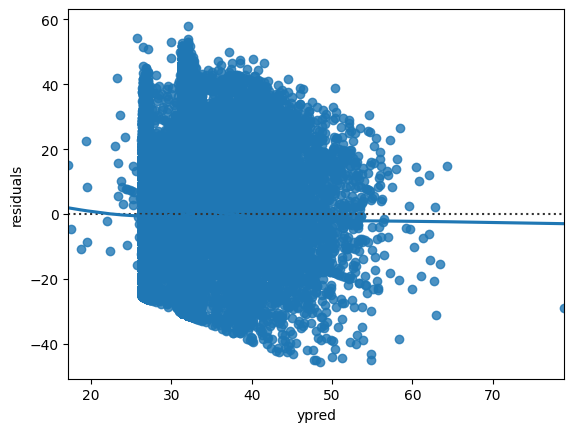

In [178]:
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('ypred')
plt.ylabel('residuals')

Comparing linear, log-regression, polinomial, the adjusted R-squared of linear regression is the highest. We may use linear regression for the final model